In [3]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [4]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [5]:
gen2 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen2_sims/data")

In [13]:
X3, y3 = format_data(gen2, 20)
print(X3.shape)
print(y3.shape)

(31151, 20, 2)
(31151, 1)


In [7]:
X3_train, y3_train, X3_test, y3_test = split_data(X3, y3, 0.8)

In [8]:
X3_train, y3_train, X3scale, y3scale = normalise_data(X3_train, y3_train)
X3_test, y3_test, _, _ = normalise_data(X3_test, y3_test)

In [14]:
print(X3scale.mean_)
print(X3scale.var_)
print(y3scale.mean_)
print(y3scale.var_)
print(X3_train)
print(y3_train)

[4.69423324 4.7940176 ]
[0.06078981 0.01565027]
[4.69863827]
[0.06571498]
[[[-0.36122866 -1.50955901]
  [-0.3868615  -1.50156946]
  [-0.41183593 -1.4935879 ]
  ...
  [-0.66517226 -1.41499744]
  [-0.66167657 -1.4071018 ]
  [-0.66517226 -1.40946967]]

 [[-0.3868615  -1.50156946]
  [-0.41183593 -1.4935879 ]
  [-0.44275448 -1.48561429]
  ...
  [-0.66167657 -1.4071018 ]
  [-0.66517226 -1.40946967]
  [-0.69897325 -1.4015795 ]]

 [[-0.41183593 -1.4935879 ]
  [-0.44275448 -1.48561429]
  [-0.4672438  -1.47764863]
  ...
  [-0.66517226 -1.40946967]
  [-0.69897325 -1.4015795 ]
  [-0.69456756 -1.3936971 ]]

 ...

 [[-0.22013357 -1.17532118]
  [-0.23268804 -1.16765866]
  [-0.20332446 -1.16000348]
  ...
  [-0.1916383  -1.0732487 ]
  [-0.1683665  -1.06568336]
  [-0.17649645 -1.05812517]]

 [[-0.23268804 -1.16765866]
  [-0.20332446 -1.16000348]
  [-0.23543952 -1.15235563]
  ...
  [-0.1683665  -1.06568336]
  [-0.17649645 -1.05812517]
  [-0.16527366 -1.03850726]]

 [[-0.20332446 -1.16000348]
  [-0.235439

In [22]:
lstm3=keras.Sequential() #Set up the architecture of the model

lstm3.add(layers.LSTM(units=16, input_shape=(X3_train.shape[1], X3_train.shape[2])))
lstm3.add(layers.Dropout(0.2))

lstm3.add(layers.Dense(units=1))

In [23]:
print(lstm3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
lstm3.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history3 = lstm3.fit(X3_train, y3_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 19936 samples, validate on 4984 samples
Epoch 1/10
19936/19936 [==============================] - 67s 3ms/sample - loss: 0.1959 - val_loss: 0.0037
Epoch 2/10
19936/19936 [==============================] - 45s 2ms/sample - loss: 0.0323 - val_loss: 0.0028
Epoch 3/10
19936/19936 [==============================] - 42s 2ms/sample - loss: 0.0246 - val_loss: 0.0020
Epoch 4/10
19936/19936 [==============================] - 38s 2ms/sample - loss: 0.0226 - val_loss: 0.0011
Epoch 5/10
19936/19936 [==============================] - 31s 2ms/sample - loss: 0.0201 - val_loss: 0.0029
Epoch 6/10
19936/19936 [==============================] - 30s 1ms/sample - loss: 0.0188 - val_loss: 0.0012
Epoch 7/10
19936/19936 [==============================] - 27s 1ms/sample - loss: 0.0185 - val_loss: 0.0011
Epoch 8/10
19936/19936 [==============================] - 25s 1ms/sample - loss: 0.0180 - val_loss: 9.5827e-04
Epoch 9/10
19936/19936 [==============================] - 21s 1ms/sample - loss: 0.0186 - v

In [25]:
lstm3.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm3")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm3/assets


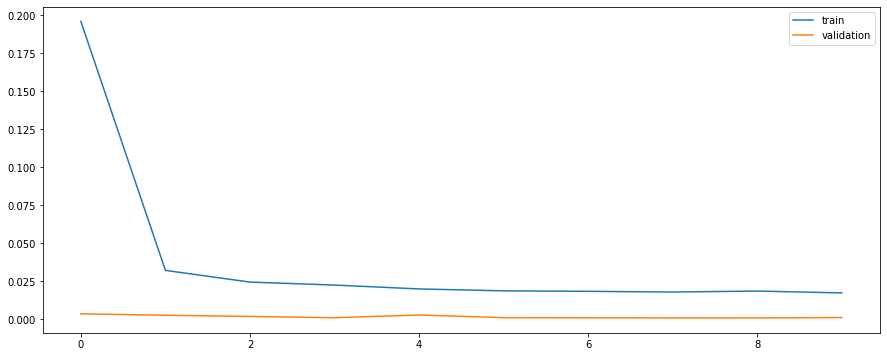

In [26]:
plt.figure(figsize=(15,6))
plt.plot(history3.history["loss"], label="train")
plt.plot(history3.history["val_loss"], label="validation")
plt.legend()

In [27]:
y3_pred = lstm3.predict(X3_test)
y3_train_inv = y3scale.inverse_transform(y3_train.reshape(1, -1))
y3_test_inv = y3scale.inverse_transform(y3_test.reshape(1, -1))
y3_pred_inv  = y3scale.inverse_transform(y3_pred)

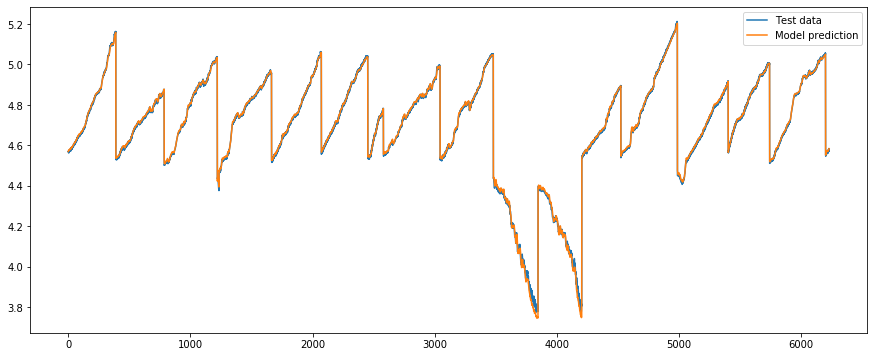

In [28]:
plt.figure(figsize=(15,6))
plt.plot(y3_test_inv.flatten(), label="Test data")
plt.plot(y3_pred_inv.flatten(), label="Model prediction")
plt.legend()